<a href="https://colab.research.google.com/github/zkatemor/audio-classification/blob/main/speech_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Speech-to-Text Model

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!ls "/content/drive/My Drive/Colab Notebooks/speech/train"

audio  LICENSE	README.md  testing_list.txt  validation_list.txt


Импортируем нужные модули.

In [5]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

Визуализация аудио-сигнала:



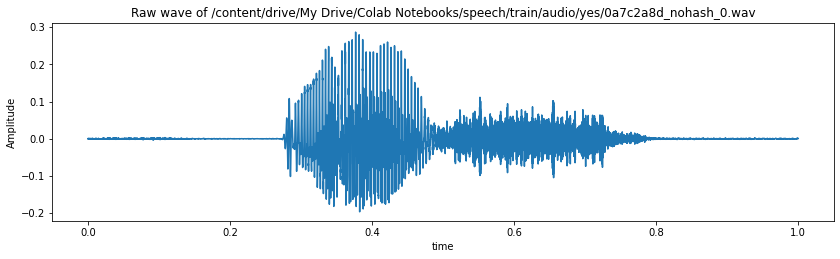

In [16]:
train_audio_path = '/content/drive/My Drive/Colab Notebooks/speech/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '/content/drive/My Drive/Colab Notebooks/speech/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

Частота дискретизации аудио-сигналов:

In [17]:
ipd.Audio(samples, rate=sample_rate)

In [18]:
sample_rate

16000

Повторная выборка

Частота дискретизации сигнала составляет 16000 Гц. Дискретизируем его до 8000 Гц, так как большинство частот, связанных с речью, присутствует в 8000 Гц.

In [19]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

Количество голосовых команд в датасете:

In [20]:
labels = os.listdir(train_audio_path)

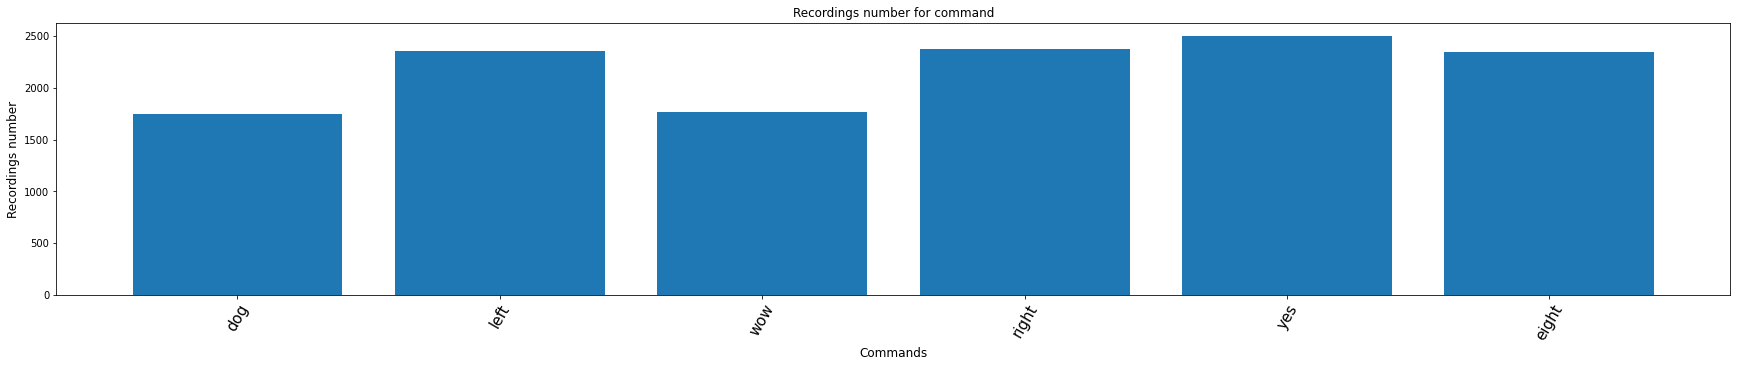

In [21]:
# находим количество записей в каждой папке
no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
# отрисовка графика
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('Recordings number', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('Recordings number for command')
plt.show()

In [22]:
labels

['dog', 'left', 'wow', 'right', 'yes', 'eight']

Распределение по продолжительности записей

(array([3.000e+00, 7.000e+00, 3.500e+01, 2.500e+01, 8.200e+01, 1.230e+02,
        2.090e+02, 1.410e+02, 2.900e+02, 1.218e+04]),
 array([0.384 , 0.4456, 0.5072, 0.5688, 0.6304, 0.692 , 0.7536, 0.8152,
        0.8768, 0.9384, 1.    ]),
 <a list of 10 Patch objects>)

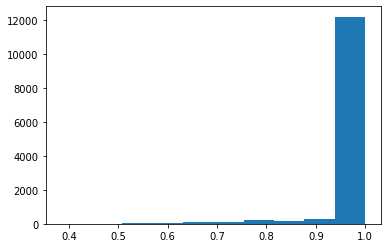

In [23]:
duration_of_recordings = []

for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

Предварительная обработка звуковых волн

По данным видно, что продолжительность нескольких записей составляет менее 1 секунды, а частота дискретизации высокая. Шаги предобработки:

1) повторная выборка (уменьшение частоты дискретизации)

2) удаление более коротких команд (менее 1 сек)

In [24]:
train_audio_path = '/content/drive/My Drive/Colab Notebooks/speech/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

dog
left
wow
right
yes
eight


Преобразование сигналов в числовое представление:

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

Преобразование числовых представление в векторное - многоклассовая классификация

In [26]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

Преобразование входных данных из двумерного в трехмерное представление (слой Conv1D)

In [27]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

Разделение данных на обучающую и тестовую

Модель будет обучаться на 80% данных и проверяться на оставшихся 20%:

In [28]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size = 0.2, random_state=777, shuffle=True)

Построение модели

Conv1В - это сверточная нейронная сеть, которая выполняет свертку только по одному измерению.

Реализация с помощью функционального API Keras.

In [40]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

# First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

# Flatten layer
conv = Flatten()(conv)

# Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

# Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

Функция потерь categorical cross-entrop, так как это задача множественной классификации:

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Ранняя остановка и контрольные точки модели - это обратные вызовы, позволяющие остановить обучение нейронной сети в нужное время и сохранить лучшую модель после каждой эпохи:

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/speech/best_speech_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [43]:
history = model.fit(x_tr, y_tr ,epochs=100, callbacks=[es, mc], batch_size=32, validation_data=(x_val, y_val))

Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 1.4915 - accuracy: 0.3398
Epoch 00001: val_accuracy improved from -inf to 0.41381, saving model to /content/drive/My Drive/Colab Notebooks/speech/best_speech_model.hdf5
296/296 [==============================] - 7s 21ms/step - loss: 1.4915 - accuracy: 0.3398 - val_loss: 1.2836 - val_accuracy: 0.4138
Epoch 2/100
293/296 [============================>.] - ETA: 0s - loss: 1.1214 - accuracy: 0.5402
Epoch 00002: val_accuracy improved from 0.41381 to 0.64337, saving model to /content/drive/My Drive/Colab Notebooks/speech/best_speech_model.hdf5
296/296 [==============================] - 6s 20ms/step - loss: 1.1202 - accuracy: 0.5409 - val_loss: 0.9656 - val_accuracy: 0.6434
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.8617 - accuracy: 0.6458
Epoch 00003: val_accuracy improved from 0.64337 to 0.69420, saving model to /content/drive/My Drive/Colab Notebooks/speech/best_speech_model.hdf5
296/296 [=

Визуализация эффективности модели:

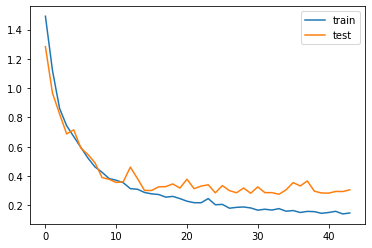

In [44]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Загружаем лучшую модель:

In [45]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/Colab Notebooks/speech/best_speech_model.hdf5')

In [152]:
def predict(audio):
    """
    функция для предсказания текста из аудио
    """
    prob = model.predict(audio.reshape(1, 8000, 1))
    index = np.argmax(prob[0])
    return classes[index]

def transform_to_class_name(prediction):
  result = []

  for item in prediction:
    index = np.where(item == 1)[0][0] if np.where(item == 1)[0] else 0
    result.append(classes[index])
  
  return result

Проверяем модель визуально:

In [47]:
import random
index = random.randint(0,len(x_val)-1)
samples = x_val[index].ravel()
print("Audio:", classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: wow


In [48]:
print("Text:",predict(samples))

Text: wow


Отчет о точности модели по тестовым данным:

In [114]:
y_predict = model.predict(x_val)
y_pred = np.rint(y_predict)

In [115]:
y_pred

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [153]:
y_predict = transform_to_class_name(y_pred)

In [155]:
y_predict[:5]

['dog', 'eight', 'left', 'yes', 'left']

In [156]:
y_true = transform_to_class_name(y_val)

In [157]:
y_true[:5]

['dog', 'eight', 'left', 'yes', 'left']

In [121]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [158]:
print("Accuracy Score:", accuracy_score(y_true, y_predict))

Accuracy Score: 0.9034307496823379


In [159]:
print("Classification Report:\n\n", classification_report(y_true, y_predict))

Classification Report:

               precision    recall  f1-score   support

         dog       0.76      0.96      0.85       310
       eight       0.98      0.93      0.96       422
        left       0.88      0.80      0.84       433
       right       0.96      0.88      0.92       433
         wow       0.94      0.92      0.93       309
         yes       0.91      0.94      0.92       454

    accuracy                           0.90      2361
   macro avg       0.90      0.91      0.90      2361
weighted avg       0.91      0.90      0.90      2361



In [161]:
confusion_matrix = confusion_matrix(y_true, y_predict)
confusion_matrix

array([[299,   0,   1,   1,   8,   1],
       [ 17, 394,   1,   8,   0,   2],
       [ 33,   3, 346,   4,   6,  41],
       [ 17,   5,  25, 383,   3,   0],
       [ 16,   1,   5,   2, 285,   0],
       [ 14,   0,  13,   1,   0, 426]])

In [163]:
import seaborn as sn
import pandas as pd

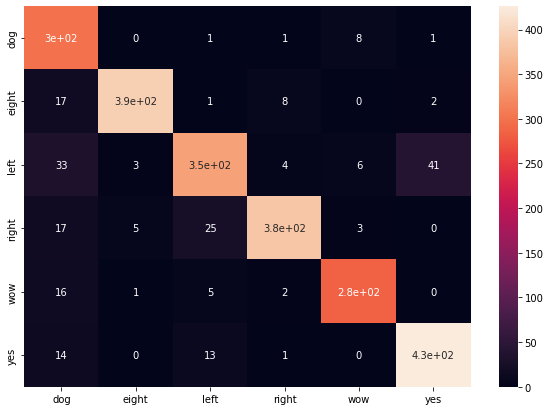

In [164]:
df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)